In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
import cv2
import numpy as np
import torch
from torchvision.transforms import Compose, Normalize, ToTensor

In [2]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [3]:
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

In [4]:
image_url = "https://farm1.staticflickr.com/6/9606553_ccc7518589_z.jpg"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(type(output), output.keys())

<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


In [5]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)

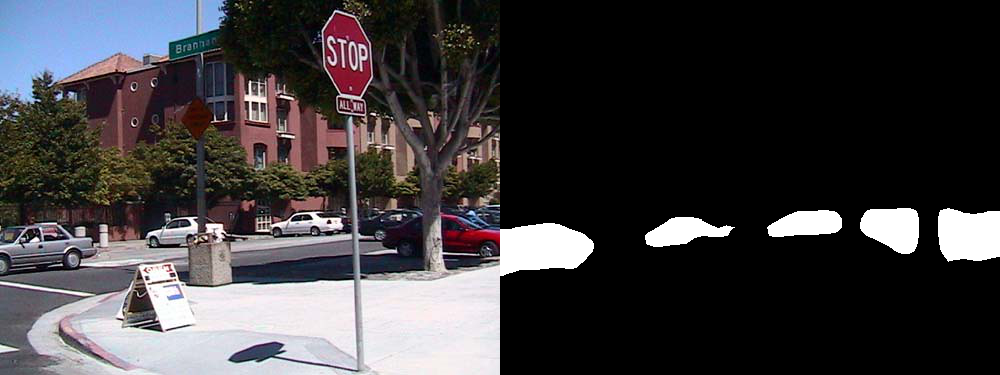

In [6]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["car"]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

In [7]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category
    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [8]:
def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(img, target_size)
        result.append(img)
    result = np.float32(result)

    return result

In [9]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

In [10]:
class BaseCAM:
    def __init__(self,
                 model,
                 target_layers,
                 use_cuda: bool = False,
                 reshape_transform = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers,
                        targets,
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets,
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets,
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets,
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets,
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


In [11]:
import numpy as np


class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        return np.mean(grads, axis=(2, 3))

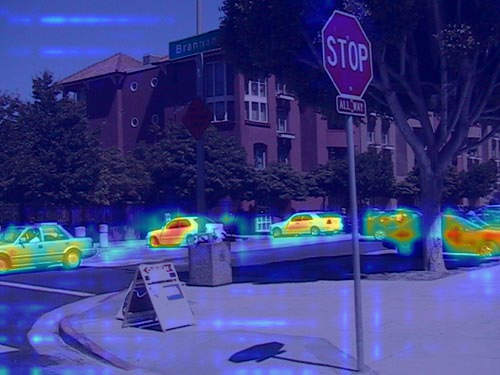

In [12]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)